
# Mask and unmasked images

1. IMPORTING THE LIBRARIES

In [ ]:
import os # reading the  files
#from tensorflow.keras.preprocessing import image


import numpy as np

import cv2
import tensorflow as tf


from tensorflow.keras.preprocessing.image import ImageDataGenerator # data augmentation
import keras,os
from keras.preprocessing.image import ImageDataGenerator # keras preprocessor
import numpy as np

from keras.models import Sequential # sequential model
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten # layers we will use in the sequential model
from keras import optimizers
from keras.optimizers import Adam # model optimizer

from keras.callbacks import ModelCheckpoint, EarlyStopping # callbacks

import matplotlib.pyplot as plt # drawing plots while training and testing

import seaborn as sns
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix

import matplotlib.pyplot as plt
import os
import numpy as np
import shutil
import random

 2. EXPLORING THE DATASET

Mounting the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


PATH TO FOLDERS IN GOOGLE COLAB

It seems to be a great dataset with approxiamtely 7000 images

In [ ]:
train_dir = '/content/drive/MyDrive/mask/train'
test_dir = '/content/drive/MyDrive/mask/test'
val_dir = '/content/drive/MyDrive/mask/val'


In [ ]:
train_normal = os.path.join(train_dir, 'normal')
train_covid = os.path.join(train_dir, 'covid')

valid_normal = os.path.join(val_dir, 'normal')
valid_covid = os.path.join(val_dir, "covid")

test_normal = os.path.join(test_dir, "normal")
test_covid = os.path.join(test_dir, 'covid')

In [ ]:
train_masked = os.path.join(train_dir, 'mask_train')
train_unmasked = os.path.join(train_dir, 'without_mask_train')

valid_masked = os.path.join(val_dir,'mask_val' )
valid_unmasked = os.path.join(val_dir, 'without_mask_val')

test_masked = os.path.join(test_dir , 'mask_test')
test_unmasked = os.path.join(test_dir, 'without_mask_test')

In [ ]:
print('Total  training images:', (len(os.listdir(train_masked)) + len(os.listdir(train_unmasked))))
print('Total validation images:', (len(os.listdir(valid_masked)) + len(os.listdir(valid_unmasked))))
print('Total testing images:', (len(os.listdir(test_masked)) + len(os.listdir(test_unmasked))))

Total  training images: 4898
Total validation images: 558
Total testing images: 379


LOOKING AT THE IMAGE

Text(0.5, 1.0, 'Masked images')

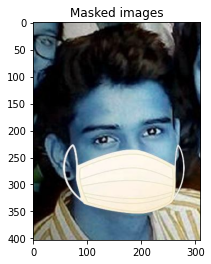

In [ ]:
masked_img =  cv2.imread('/content/drive/MyDrive/mask/train/mask_train/with_mask_1000.jpg')
plt.imshow(masked_img)
plt.title('Masked images')

Text(0.5, 1.0, 'Unmasked image')

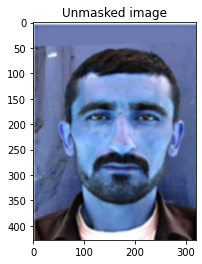

In [ ]:
unmasked_img =  cv2.imread('/content/drive/MyDrive/mask/train/without_mask_train/without_mask_1208.jpg')
plt.imshow(unmasked_img)
plt.title('Unmasked image')

2. Data Augmentation 
https://keras.io/api/preprocessing/image/


The objective of ImageDataGenerator is to import data with labels easily into the model. It is a very useful class as it has many function to rescale, rotate, zoom, flip etc. The most useful thing about this class is that it doesn’t affect the data stored on the disk. 

As this one of the first data augmentation, I used the code mentioned in the keras documentaion and re-used it.

In [ ]:
train_data_generator= ImageDataGenerator(rescale=1./255,zoom_range=0.2,vertical_flip=True) # same as in keras documentataion 
train_generator=train_data_generator.flow_from_directory(directory=train_dir, 
                                         batch_size=100, #chose a size at random
                                         target_size =(255,255), # assumed a target size
                                         shuffle=True,
                                         class_mode = 'binary')

val_data_generator= ImageDataGenerator(rescale=1./255,zoom_range=0.2,vertical_flip=True)
val_generator=val_data_generator.flow_from_directory(directory=val_dir, 
                                         batch_size=100,
                                         target_size =(255,255),
                                         shuffle=True,
                                         class_mode = 'binary')

test_data_generator= ImageDataGenerator(rescale=1./255,zoom_range=0.2,vertical_flip=True)
test_generator=test_data_generator.flow_from_directory(directory=test_dir, 
                                         batch_size=100,
                                         target_size =(255,255),
                                         shuffle=True,
                                         class_mode = 'binary')
# The function ImageDataGenerator augments your image by iterating through image as your CNN is getting ready to process that image

Found 4963 images belonging to 2 classes.
Found 558 images belonging to 2 classes.
Found 379 images belonging to 2 classes.


In [ ]:


from keras.layers import Dense, Activation, Flatten, Dense,MaxPool2D, Dropout
from keras.layers import Conv2D, MaxPool2D, BatchNormalization #
from keras.callbacks import ModelCheckpoint, EarlyStopping # callbacks



3. Defining the transfer learning model - *MobilNet*


In [ ]:
from keras.applications import MobileNet
base_model = MobileNet(include_top=False, weights='imagenet',
            input_shape=(255,255,3), classes=2)

17227776/17225924 [==============================] - 0s 0us/step


In [ ]:
#Adding layers to base model of MobileNet

model = Sequential()

#Creating base layer of mobilnet
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())

#Adding the Dense Layers and Dropout
model.add(Dense(512,activation=('relu'))) 

model.add(Dense(256,activation=('relu'))) 

model.add(Dropout(.3))

model.add(Dense(128,activation=('relu')))

model.add(Dropout(.2))

model.add(Dense(1,activation=('sigmoid')))

In [ ]:
#Visualizing Model Summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 8, 8, 1024)        3228864   
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 8, 1024)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               33554944  
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)              

DEFINING THE CALLBACKS

In [ ]:
model_name = "best_model.h5"
#CALLBACK - 1 - early_stop
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy' , patience = 5) 
'''EarlyStopping helps us to stop the training of the model early if there is no increase 
in the parameter which I have set to monitor in EarlyStopping. In this case I am monitoring validation 
accuracy by passing val_acc to EarlyStopping. I have here set patience to 5 which means that the model 
will stop to train if it doesn’t see any rise in validation accuracy in 5 epochs.'''
# if for 5 epochs the val_acc does not improve the training is going to be intereppupted
#patience is how long the model is going to train without interuppting

#CALLBACK - 2 - monitor
monitor = tf.keras.callbacks.ModelCheckpoint (model_name, monitor = 'val_accuracy',save_best_only = True , save_weights_only = True )
# you save the best model and the weights
#the callback is going the keep on checking the validation error and if the validation error decreases then we will save the model as the best model
# mode is whether u wabnt to save the minimum or maximum value of the cost function, we are not defining mode as it is automatically defined defined by tf
'''
ModelCheckpoint helps us to save the model by monitoring a specific parameter of the model. 
In this case I am monitoring validation accuracy by passing val_acc to ModelCheckpoint. 
The model will only be saved to disk if the validation accuracy of the model in current 
epoch is greater than what it was in the last epoch.
'''

#CALLBACK - 3 - lr_schedule
def scheduler(epoch, lr):
  if epoch%10==0:  #every 10 epoch reduce the learning rate by a factor of 2 
    lr = lr/2
  return lr
  
lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)# definding the callback

In [ ]:
#Compiling Model using SGD 

model.compile(loss = 'binary_crossentropy', optimizer = 'adam',
              metrics = ['accuracy'])

In [ ]:
hist = model.fit_generator(steps_per_epoch=7,generator=train_generator, validation_data= val_generator, epochs=400,verbose = 1,callbacks = [early_stop, monitor, lr_schedule],  shuffle = True)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/400
7/7 [==============================] - 409s 57s/step - loss: 2.3740 - accuracy: 0.5802 - val_loss: 1.1514 - val_accuracy: 0.5323
Epoch 2/400
7/7 [==============================] - 269s 36s/step - loss: 0.6613 - accuracy: 0.8385 - val_loss: 0.1624 - val_accuracy: 0.9534
Epoch 3/400
7/7 [==============================] - 255s 34s/step - loss: 0.1387 - accuracy: 0.9537 - val_loss: 0.0294 - val_accuracy: 0.9964
Epoch 4/400
7/7 [==============================] - 247s 34s/step - loss: 0.1622 - accuracy: 0.9811 - val_loss: 0.0836 - val_accuracy: 0.9875
Epoch 5/400
7/7 [==============================] - 253s 35s/step - loss: 0.1555 - accuracy: 0.9706 - val_loss: 0.0063 - val_accuracy: 0.9982
Epoch 6/400
7/7 [==============================] - 241s 34s/step - loss: 0.1870 - accuracy: 0.9769 - val_loss: 0.0044 - val_accuracy: 0.9982
Epoch 7/400
7/7 [==============================] - 242s 34s/step - loss: 0.0279 - accuracy: 0.9911 - val_loss: 1.9382e-05 - val_accuracy: 1.0000
Epoch 8/4

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


7/7 [==============================] - 223s 32s/step - loss: 0.3280 - accuracy: 0.9727 - val_loss: 1.1058e-07 - val_accuracy: 1.0000
Epoch 10/400
7/7 [==============================] - 231s 33s/step - loss: 0.0883 - accuracy: 0.9864 - val_loss: 1.0091e-10 - val_accuracy: 1.0000
Epoch 11/400
7/7 [==============================] - 226s 32s/step - loss: 0.0255 - accuracy: 0.9906 - val_loss: 5.8665e-08 - val_accuracy: 1.0000
Epoch 12/400
7/7 [==============================] - 225s 32s/step - loss: 0.0410 - accuracy: 0.9838 - val_loss: 2.3229e-06 - val_accuracy: 1.0000


PLOTTING THE TEST AND VALIDATION ACCURCIES AND LOSES

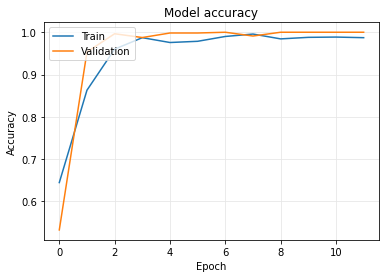

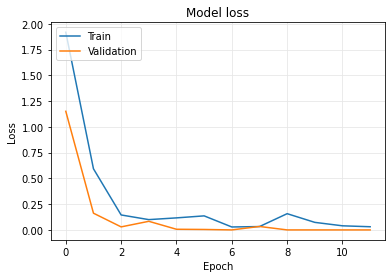

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(color='#e6e6e6')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid(color='#e6e6e6')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

7.TESTING THE MODEL ON THE TEST SET AND EXTRACTING RELEVANT METRICS

In [ ]:
model.evaluate(test_generator)

4/4 [==============================] - 76s 23s/step - loss: 0.7448 - accuracy: 0.9314


[0.7447828650474548, 0.9313983917236328]

In [ ]:
model.load_weights(model_name) # here the weight we are produced during model training
metrics = model.evaluate(test_generator) # it will return the loss and metrics when we are testing the model # here we have categorical cross entropy here is loss and accuracy is the metrics
#print(metrics) # in step 4 we stated that we wan to measure and monitor two metrics
print("Binary cross-entropy:" , metrics[0])
print("Accuracy:" , metrics[1])

4/4 [==============================] - 24s 5s/step - loss: 0.5805 - accuracy: 0.9578
Binary cross-entropy: 0.5805022120475769
Accuracy: 0.9577836394309998


The model is fully conveged and has an accuracy of 96% and a loss of 0.58.

CONFUSION MATRIX

In [ ]:
y_pred = model.predict_generator(test_generator)
y_true = test_generator.classes
y_pred = y_pred > 0.5

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


                    precision    recall  f1-score   support

        mask_train       0.51      0.56      0.53       187
without_mask_train       0.53      0.48      0.50       192

          accuracy                           0.52       379
         macro avg       0.52      0.52      0.52       379
      weighted avg       0.52      0.52      0.52       379



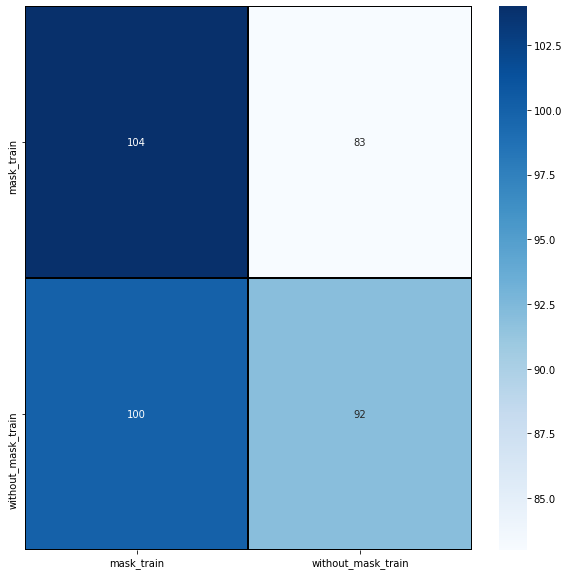

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import seaborn as sns

# classification report
target_names = train_generator.class_indices

print(classification_report(y_true, y_pred, target_names=target_names))

# confusion matrix
mat = confusion_matrix(y_true, y_pred)
cm = pd.DataFrame(mat, index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , 
            annot = True, fmt='',xticklabels = target_names, yticklabels = target_names)

In [ ]:
# Define 1:  train & validation loss
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

## Define 2: train & validation AUC
train_auc_name = list(hist.history.keys())[3]
val_auc_name = list(hist.history.keys())[1]
train_auc = hist.history[train_auc_name]
val_auc = hist.history[val_auc_name]

## Define 3: y_pred & y_true : y_test
prediction_probability = model.predict(test_generator) 
prediction_class= model.predict_classes(test_generator)
y_pred = (prediction_class > 0.5).T[0]
y_pred_prob = prediction_probability.T[0]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

[Classification Metrics Summary]
Accuracy = 50.92% | Precision = 51.70% | Recall = 47.40% | Specifity = 54.55% | F1 Score = 49.46%


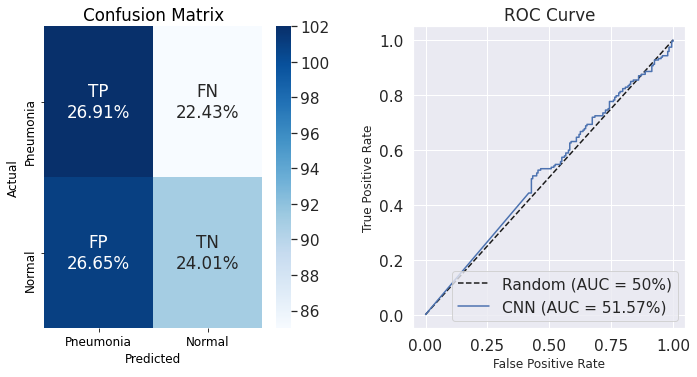

In [ ]:
fig = plt.figure(figsize=(10, 10))

y_test = test_generator.classes
# PLOT 3: CONFUSION MATRIX
plt.subplot(2,2,1)

    # Set up the labels for in the confusion matrix
cm = confusion_matrix(y_test, y_pred)
names = ['TP', 'FN', 'FP', 'TN']
counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
labels = np.asarray(labels).reshape(2,2)
ticklabels = ['Pneumonia','Normal']

    # Create confusion matrix as heatmap
sns.set(font_scale = 1.4)
ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', xticklabels=ticklabels, yticklabels=ticklabels )
plt.xticks(size=12)
plt.yticks(size=12)
plt.title("Confusion Matrix")
plt.xlabel("Predicted", size= 12)
plt.ylabel("Actual", size= 12) 

# PLOT 4: ROC CURVE
plt.subplot(2,2,2)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label = "Random (AUC = 50%)")
plt.plot(fpr, tpr, label='CNN (AUC = {:.2f}%)'.format(auc*100))
plt.xlabel('False Positive Rate', size = 12)
plt.ylabel('True Positive Rate', size = 12)
plt.legend(loc='best')

# END PLOTS
plt.tight_layout()

# Summary Statistics

    #Accuracy : 1 - (Average Classification Error) = (TP + TN) / (TP + FN + TN + FP)  --> % positive out of all predicted positives
    #Precision : how many selected items are relevant = TP / (TP + FP)                --> % positive out of all predicted positives
    #Recall : how many relevant items are selected = TP / (TP + FN)                   --> % positive out of all supposed to be positives
    #Specifity :                                                                      --> % negative out of all supposed to be negatives
    #F1-score : harmonic mean between Precision and Recall = (2*precision * recall) / (precision + recall)

#cm[0,0], cm[0, 1], cm[1, 0], cm[1, 1]
TN, FP, FN, TP = cm.ravel()         
accuracy = (TP + TN) / np.sum(cm)   
precision = TP / (TP+FP)            
recall =  TP / (TP+FN)              
specifity = TN / (TN+FP)           
f1 = 2 * precision * recall / (precision + recall)
stats_summary = '[Classification Metrics Summary]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | Specifity = {:.2%} | F1 Score = {:.2%}'.format(accuracy, precision, recall, specifity, f1)
print(stats_summary)